<font><div><center> 
# Failure to Engage Closed-Loop Guiding During Global Alignment
</center></div></font> 

This notebook is for the case that guiding fails during Global Alignment (1 or 2) Adjust1/Correct and Adjust2/Correct+Adjust observations due to a failure of ID, ACQ, or TRK when trying to engage closed-loop guiding after a mirror move. 

**Jupyter Notebook Help:** To run a cell, press Shift+Enter on your keyboard

<font color='white'><div style='background-color: rgba(255, 99, 71)'> 
This notebook currently has this set up with GA 1 data from MIRAGE. If you need to use this for commissioning, save a copy of this notebook and replace the indicated options in the cells below with the necessary information. 
</div></font>

In [1]:
# Import necessary packages

# Standard Library
from glob import glob
import os
from io import StringIO
from functools import reduce

# Third Party Packages
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd

%matplotlib inline

# Guiding Failure in OTE-07

* [Before running this notebook](#Before-running-this-notebook)
* [Parameters to change](#Parameters-to-change)
* [Examine the data from the failed observation](#Examine-the-data-from-the-failed-observation)
* [Compare the Guiding Selections with the Bright Object List](#Compare-the-Guiding-Selections-with-the-Bright-Object-List)
* [Determine Likely Cause of Failure](#Determine-Likely-Cause-of-Failure)
* [Where do we go from here?](#-Where-do-we-go-from-here?)

<font color='SlateBlue'> <div> 
### Before running this notebook:
###    
</div></font>
1. Make a directory to store all the data for this analysis (I recommend doing this where we save the data, and naming the directory "ga_failure")

2. Copy all NIRCam and FGS full frame data that was successfully taken to the above directory

3. Make a subdirectory for each attempt of track that has data (the failed attempt will at least have ID data and we want to include this)

4. Move all guiding products (ID, ACQ, TRK data) for the guiding attempts to their respective directories

5. For easy access, you can also move the ID.star file and ACQ.prc file that you made from the LOS-02 observation 2 data for OTE-07 obs 1 to a `command` directory

    This is what this might look like (this is an example for if it failed on the second guiding attempt in ID):
    ```
    - ga_failure/
        - command/
            - for_ote07_obs1_G1_ID.star
            - for_ote07_obs1_G1_ACQ.prc
        - track_attempt_1/
            - config_1
                - gs-idstrips.fits
                - gs-acq1.fits
                - gs-acq2.fits
                - gs-track.fits
        - track_attempt_2/
            - config_1
                - gs-idstrips_set1.fits
                - gs-idstrips_set2.fits
                - gs-idstrips_set3.fits
        - jw01141001001_02101_00001_nrca3_cal.fits
        - jw01141001001_02101_00002_nrca3_cal.fits
        - jw01141001001_03101_00001_g1_cal.fits
    ```

    You will have one set of ID strips for each of the three attempts to get into ID for each configuration that you included in the override file. In the above example, only one configuration was commanded (for simplicity). 
    

6. Run one of the retrieved ID strips (if you have multiple configurations, do this for each configuration) from the failed attempt through DHAS, using the ID.star file in the `command` directory. This will hopefully show that the run fails. If it succeeds, this is something that will need to be discussed with the FGS team. *If the DHAS is not a good measure of what we can expect form the FSW, that is a discrepancy that we need to understand.* 

    From the DHAS run, we want the bright object list (.bobj) so we know the count rates actually measured for each PSF so that we can compare this to what we commanded with out override file. 


<font color='Tomato'> <div style='background-color: rgba(255, 99, 71, 0.3)'><center> 
##    
## You will not be able to run this notebook without changing the below parameters
##    
</center></div></font>

<font><div><center> 
## Parameters to change 
</center></div></font>  

To run this notebook for your data set where guiding has failed, you will need to change the parameters in the call below to match your data. This notebook is set up such that this is the ONLY cell you should have to update. 

In [2]:
# Values that have been set in MAGIC

threshold = .6  # Value in MAGIC to set the count rate threshold
guider = 1  # FGS dectector that will be used for observation 1 -- this will always be 1 for OTE-07/GA1
nrc_detector = 'A3'  # NIRCam detector used for NIRCam observations

In [51]:
# CAR information 

program_id = 1141 # GA1; use 1151 for GA2
observation = 1

In [34]:
# Information about the command used to for the override

# Out Directory passed intp MAGIC
commanded_out_dir = '***REMOVED***/share/wf_guiding/ga_guiding_failure_analysis_plan' 

# Root passed into MAGIC
root_psuedo_fgs = f'for_ote07_obs{observation}'

# Check that there is data at that location
if not os.path.exists(os.path.join(commanded_out_dir, 'out', root_psuedo_fgs)):
    print("ERROR: The directory that you listed does not exist. Check that is it is pointing to the correct place.")

In [91]:
# The location of data from the observatory
failed_observation_products = '***REMOVED***/share/wf_guiding/ga_guiding_failure_analysis_plan/ga_failure'

# For each step where you have the data, provide the filename of the images in the above directory
# It's likely that the below filenames are already correct, but be sure to check them!
# If you do not have all of this data, you can delete the file name or comment out the line, or leave it as is
#  the code is smart enough to know if what you don't have and not look for it

#  --Before the first mirror move--
nrc_track_1_filename = f'jw{program_id:04d}{observation:03d}001_02101_00001_nrca3_cal.fits'

#  --After the first mirror move--
nrc_coarse_1_filename = f'jw{program_id:04d}{observation:03d}001_02101_00002_nrca3_cal.fits'
fgs_coarse_1_filename = f'jw{program_id:04d}{observation:03d}001_03101_00001_g1_cal.fits'
nrc_track_2_filename = f'jw{program_id:04d}{observation:03d}001_05101_00001_nrca3_cal.fits'

# If applicable
#  --After the second mirror move--
nrc_coarse_2_filename = f'jw{program_id:04d}{observation:03d}001_05101_00002_nrca3_cal.fits'
fgs_coarse_2_filename = f'jw{program_id:04d}{observation:03d}001_06101_00001_g1_cal.fits'

jw1141001001_02101_00001_nrca3_cal.fits


In [92]:
# What track attempt did it fail on?
fail_attempt = 3

### Run all cells below for each configuration
Starting with the next cell, for each config, be sure to update the config_number and run all subsequent cells to the end, being sure to record the likely cause of failure for each config as you run them. 

In [102]:
# Config number - you will run the cells below for each 
# Number associated with the config used for the commands.
config_number = 1

# The bright object list that will come out of running the failed ID strips through DHAS
# If you have multiple configs, you might have to change the path below
bright_object_list = glob(os.path.join(failed_observation_products, 
                                       f'track_attempt_{fail_attempt}', 
                                       f'config_{config_number}',
                                       'idSim_cfg_default_*.bobj'))[0]
print(bright_object_list)

***REMOVED***/share/wf_guiding/ga_guiding_failure_analysis_plan/ga_failure/track_attempt_3/config_1/idSim_cfg_default_20210727_105820.bobj


<font color='DodgerBlue'> <div style='background-color: rgba(30, 144, 255, 0.3)'><center> 
##    
## Run the following cells without changing them
##    
</center></div></font>

<font><div><center> 
# Examine the data from the failed observation
</center></div></font>  

All of the data below is in the SCI frame which is different from the frame the the MAGIC products are in. The plots below are informative *only* and are not meant to be used to extrapolate information.

In [57]:
# Open the images
try: 
    nircam_track_1 = fits.getdata(os.path.join(failed_observation_products, nrc_track_1_filename))

    nircam_coarse_1 = fits.getdata(os.path.join(failed_observation_products, nrc_coarse_1_filename))
    fgs_coarse_1 = fits.getdata(os.path.join(failed_observation_products, fgs_coarse_1_filename))
    try:  
        nircam_track_2 = fits.getdata(os.path.join(failed_observation_products, nrc_track_2_filename))
        mirror_move_2 = True
    except (FileNotFoundError, IsADirectoryError, NameError):
        print('Observation failed to get into track after first mirror move')
        mirror_move_2 = False

    if mirror_move_2:
        nircam_coarse_2 = fits.getdata(os.path.join(failed_observation_products, nrc_coarse_2_filename))
        fgs_coarse_2 = fits.getdata(os.path.join(failed_observation_products, fgs_coarse_2_filename))
except (FileNotFoundError, IsADirectoryError, NameError):
    print('Observation failed to get into track on the first attempt. Only guider data will be available.')

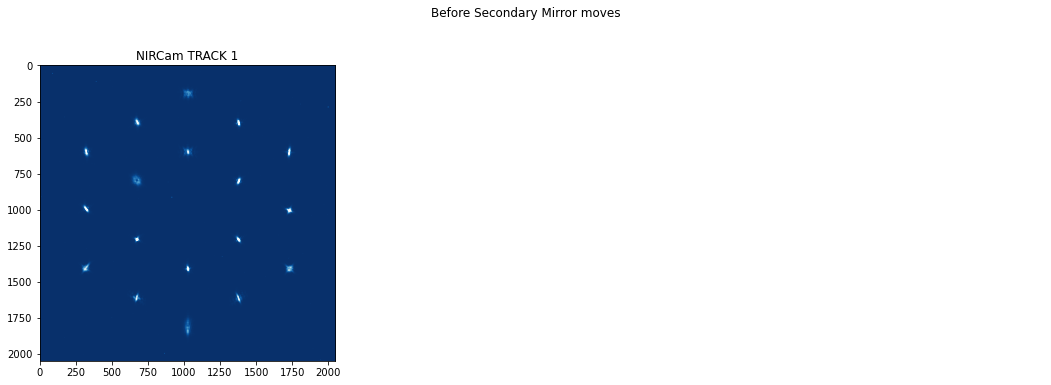

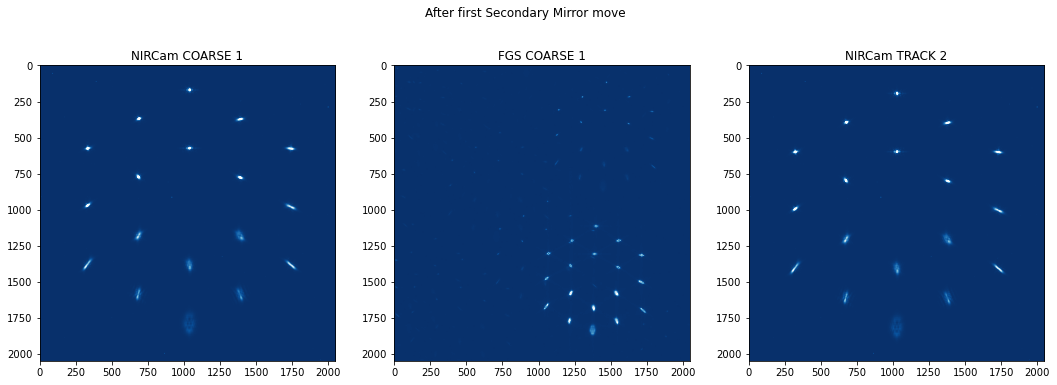

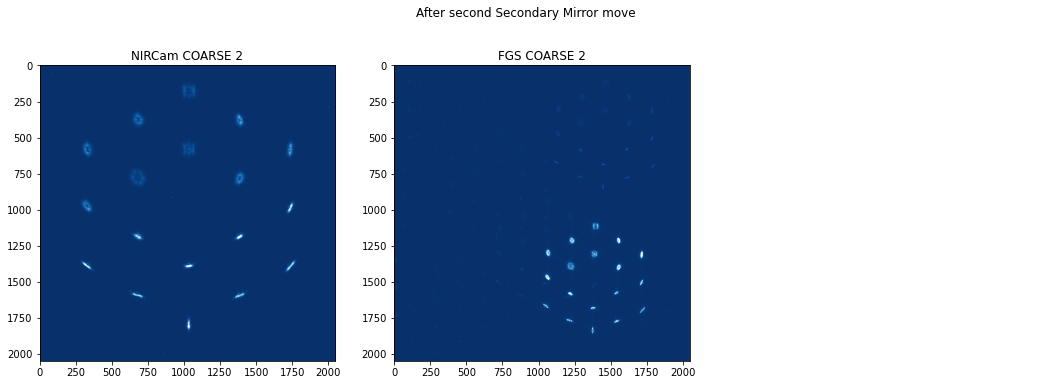

In [141]:
# Plot images
# Note that all images have the origin in the UPPER LEFT, matching the MAGIC orientation
try:
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(nircam_track_1, cmap='Blues_r', vmin=0, vmax=10000, origin='upper')
    ax[0].set_title('NIRCam TRACK 1')
    ax[1].axis('off')
    ax[2].axis('off')
    fig.suptitle("Before Secondary Mirror moves")
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(nircam_coarse_1, cmap='Blues_r', vmin=0, vmax=10000, origin='upper')
    ax[0].set_title('NIRCam COARSE 1')
    ax[1].imshow(fgs_coarse_1, cmap='Blues_r', vmin=0, vmax=50, origin='upper')
    ax[1].set_title('FGS COARSE 1')
    fig.suptitle("After first Secondary Mirror move")

    try:
        ax[2].imshow(nircam_track_2, cmap='Blues_r', vmin=0, vmax=10000, origin='upper')
        ax[2].set_title('NIRCam TRACK 2')
        plt.show()

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        ax[0].imshow(nircam_coarse_2, cmap='Blues_r', vmin=0, vmax=10000, origin='upper')
        ax[0].set_title('NIRCam COARSE 2')
        ax[1].imshow(fgs_coarse_2, cmap='Blues_r', vmin=0, vmax=50, origin='upper')
        ax[1].set_title('FGS COARSE 2')
        ax[2].axis('off')
        fig.suptitle("After second Secondary Mirror move")
        
    except NameError:
        plt.show()
        print('Failure after first Secondary Mirror move')
except NameError:
    print('No full frame data NIRCam or FGS to show')

For reference:
<img src="psf_orientation_sci_magic.png" style="width: 300px;">

<font><div><center> 
# Compare the Guiding Selections with the Bright Object List
</center></div></font>
    
Take the ID strips for a failed run (from sky/MAST) and run them through the DAHS to get bright object list Compare the bright object list to the command

In [103]:
print(f"Running for config {config_number}")

Running for config 1


### Bright Object List

In [105]:
# Print the bright object list filename
bright_object_list

'***REMOVED***/share/wf_guiding/ga_guiding_failure_analysis_plan/ga_failure/track_attempt_3/config_1/idSim_cfg_default_20210727_105820.bobj'

In [106]:
# Read the bright object list into a table (Data Frame)
bright_object_df = pd.read_csv(bright_object_list)

# Display the table
bright_object_df

,Cand#,Strip#,CDS#,FPA Row (pixels),FPA Column (pixels),FPA Peak Signal (counts),FPA Count Sum (counts)
0,0,10,1,548,747,6103,43139
1,1,13,1,716,480,4737,35405
2,2,13,2,708,641,3796,28817
3,3,10,2,540,553,3519,25706
4,4,7,1,375,823,3458,25530
5,5,19,1,1040,655,3296,24653
6,6,7,2,381,810,3497,25470
7,7,16,1,884,558,3037,23198
8,8,10,2,557,547,3075,22368
9,9,7,2,377,620,3043,22100


In the above dataframe, the 'FPA Column (pixels)' column corresponds to 'x', the 'FPA Row (pixels)' column corresponds to 'y', and the 'FPA Count Sum (counts)' is our 3x3 count rate that is labelled 'countrate' in the guiding selections file.

In [107]:
psuedo_fgs = fits.getdata(glob(os.path.join(commanded_out_dir, 'out', root_psuedo_fgs, 
                                            f'guiding_config_{config_numbers[0]}',
                                            'FGS_imgs', '*.fits'))[0])

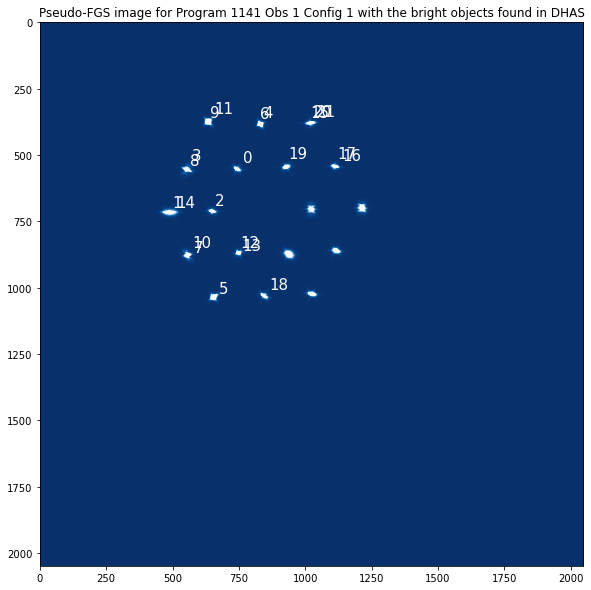

In [138]:
# Plot the bright objects that made this list on top of the Pseudo FGS image that you made when you made 
#  the command
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')

for i, (column, row) in enumerate(zip(bright_object_df['FPA Column (pixels)'].values, 
                                  bright_object_df['FPA Row (pixels)'].values)):
    plt.annotate(i, (column, row), (column+20, row-20), color='white', fontsize=15)

plt.title(f'Pseudo-FGS image for Program {program_id} Obs {observation} Config {config_number} with the bright objects found in DHAS')
plt.show()

### Guiding Selections 

In [110]:
# Guiding selections file
# The first row is the guide star, subsequent rows are reference stars. Order of ref stars doesn't matter.
commanded = pd.read_csv(os.path.join(commanded_out_dir, 'out', root_psuedo_fgs, 
                                     f'guiding_config_{config_numbers[0]}', 
                                     f'shifted_guiding_selections_{root_psuedo_fgs}_G{guider}_config{config_number}.txt'),
                        skiprows=1, delimiter=' ', names=['y', 'x', 'countrate'])

# Add the count rate threshold to the table
thresholds = threshold * commanded['countrate'].values

commanded['threshold'] = thresholds

# Display the table
print(f'The Guide and Reference PSFs commanded values for Config {config_number}')
commanded

The Guide and Reference PSF commanded values for Config 1


,y,x,countrate,threshold
0,1023.5,1023.5,84046.0,50427.6
1,1034.5,653.5,44164.0,26498.4
2,374.5,632.5,33700.0,20220.0


The first entry (index 0) is your guide star. The next two entries (indices 1 and 2) are your reference stars

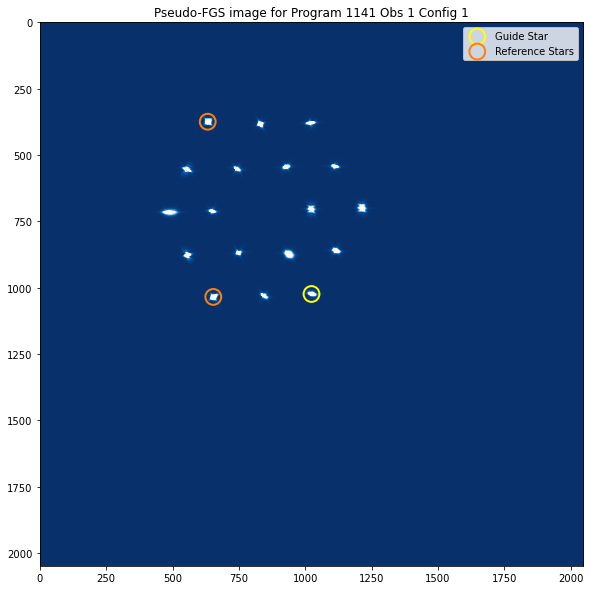

In [148]:
# Plot it
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
plt.scatter(commanded['x'].values[0], commanded['y'].values[0], s=250, facecolors='none',  edgecolors='yellow',
            linewidths=2.0, label='Guide Star')
plt.scatter(commanded['x'].values[1:], commanded['y'].values[1:], s=250, facecolors='none',  edgecolors='C1',
            linewidths=2.0, label="Reference Stars")
plt.legend()
plt.title(f'Pseudo-FGS image for Program {program_id} Obs {observation} Config {config_number}')
plt.show()

### Cross-match the bright object list and the guiding selections/command

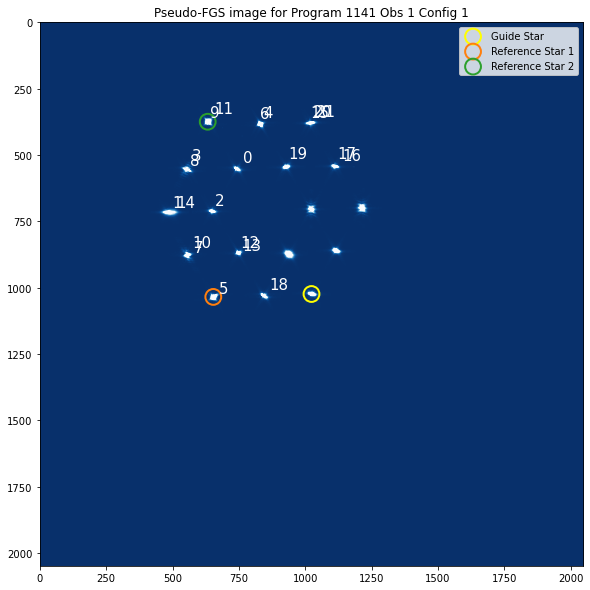

In [149]:
# Plot it
plt.figure(figsize=(12, 10))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
plt.scatter(commanded['x'].values[0], commanded['y'].values[0], s=250, facecolors='none',  edgecolors='yellow',
            linewidths=2.0, label='Guide Star')
plt.scatter(commanded['x'].values[1], commanded['y'].values[1], s=250, facecolors='none',  edgecolors='C1',
            linewidths=2.0, label="Reference Star 1")
plt.scatter(commanded['x'].values[2], commanded['y'].values[2], s=250, facecolors='none',  edgecolors='C2',
            linewidths=2.0, label="Reference Star 2")
for i, (column, row) in enumerate(zip(bright_object_df['FPA Column (pixels)'].values, 
                                  bright_object_df['FPA Row (pixels)'].values)):
    plt.annotate(i, (column, row), (column+20, row-20), color='white', fontsize=15)
plt.legend()
plt.title(f'Pseudo-FGS image for Program {program_id} Obs {observation} Config {config_number}')
plt.show()

<font><div><center>
# Determine Likely Cause of Failure
</center></div></font>

Before getting to the likely causes of failure, there are two main ways to move forward to make an override file for a repeat of this observation (which may not be required):

**Recommendation 1:** Go back and make a new command with the same star selections with wider threshold value (only up to 90%) 

**Recommendation 2:** Make new selections. What you choose will depend on at what point in the observation you failed, and if you have to move through all the mirror moves again. 

The complete instructions for each of these recommendations can be found back on the [Guiding Contingencies](https://jwstitarwiki.stsci.edu/display/WFSCOWG/Guiding+Contingencies) page.

In the below checks, you will be directed to which of these will make the most sense. 

Note that in every case, **before proceeding to make another override file, you need to check in with the FGS team and WF Ops**. You need to know what the next observation will be and what kind of override file will be necessary before continuing (i.e. Are there any mirror moves? Is the observation being repeated or is a new observation being executed?)

<font color='SlateBlue'> <div>

## CHECK 1: Did the selected/commanded guide and reference PSFs even make it on the bright object list?    
 
</div></font>

<font color='MediumSeaGreen'><div>
### Yes
</div></font>

If you also found that when running this commmand through DHAS, it was successful, this all makes sense, but does point to a discrapancy between the DHAS and the FSW. **Reach out to the FGS team to compare results.**


If this configuration failed in the DHAS test, are the Guide and Reference PSFs close together or in a non-unique configuration? If the answer to this is yes, then you will probably have to follow **Recommendation 2**, being sure to test your config any ID images that you have that represent the mirror state(s) that will happen in the follow-up observation(s). Be sure to reference [this page](https://jwstitarwiki.stsci.edu/display/WFSCOWG/Selecting+Guide+and+Reference+Stars#SelectingGuideandReferenceStars-segmentgeometrySegmentGeometry) along with consulting how the PSFs have changed across mirror moves, when making new selections.



<font color='Tomato'><div>
### No
</div></font>

This is probably why guiding failed - the **FGS team will be able to confirm this so be sure to check that they agree**. 

Which recommendation is necessary will depend on which segments were selected for your configs. Go back to the Full Frame images we got and see if the selected PSFs got donut-y after the mirror move(s) to the point where even opening the threshold, would not be sufficient. If you aren't sure just by looking, start with Recommendation 1 and see if you can still use the same configuration(s) with a wider threshold (remember that you must use the same threshold for all configurations).

Recall the selections we chose

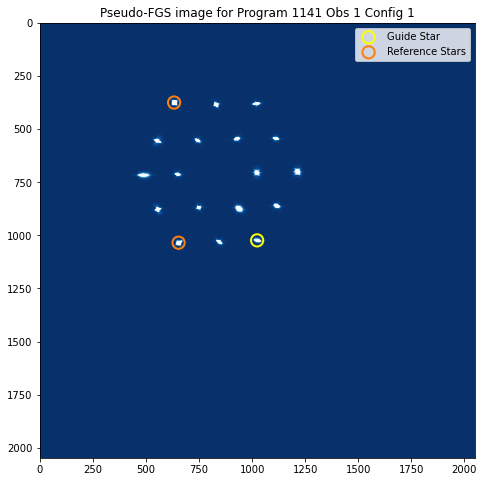

In [144]:
# Plot it
plt.figure(figsize=(10, 8))
plt.imshow(psuedo_fgs, cmap='Blues_r', vmin=0, vmax=1000, origin='upper')
plt.scatter(commanded['x'].values[0], commanded['y'].values[0], s=150, facecolors='none',  edgecolors='yellow',
            linewidths=2.0, label='Guide Star')
plt.scatter(commanded['x'].values[1:], commanded['y'].values[1:], s=150, facecolors='none',  edgecolors='C1',
            linewidths=2.0, label="Reference Stars")
plt.legend()
plt.title(f'Pseudo-FGS image for Program {program_id} Obs {observation} Config {config_number}')
plt.show()

Check which segments (WSS numbering) were selected so you can compare with the retreived full frame images

<table><tr><td><img src="../../jwst_magic/data/fgs_raw_orientation_numbering_wss_guider1.png" style="width: 400px;"></td><td><img src="../../jwst_magic/data/fgs_raw_orientation_numbering_wss_guider2.png" style="width: 400px;"></td></tr></table>

In the example we are using Guider 1: B6, B5, B3

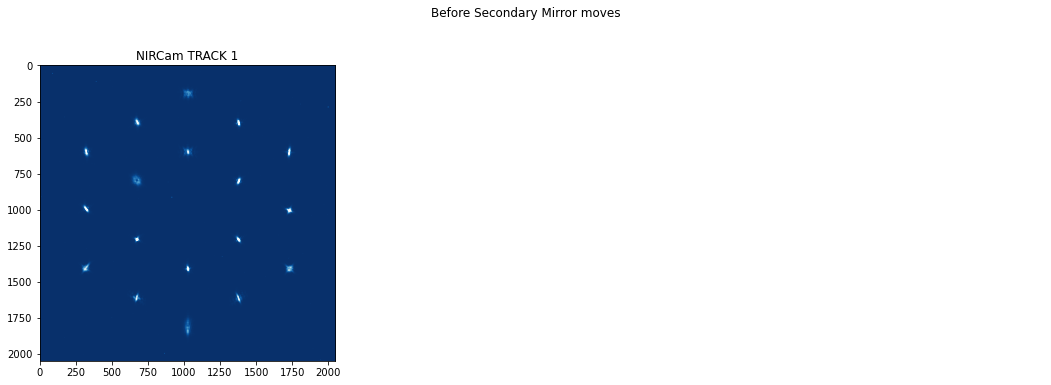

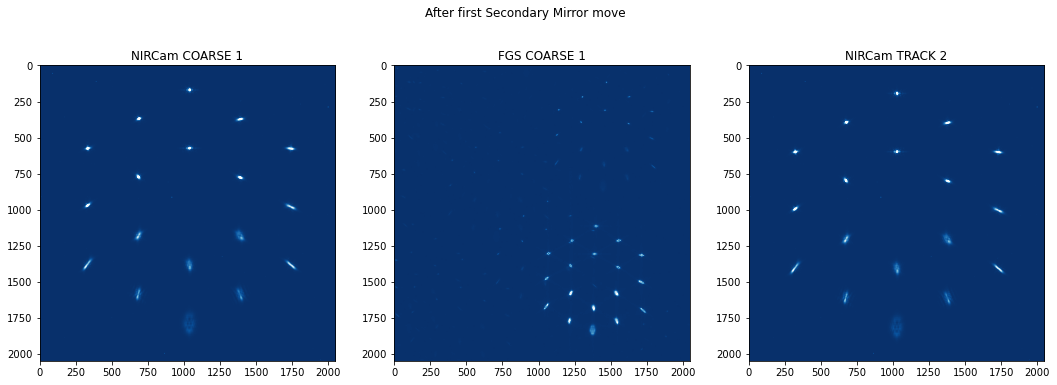

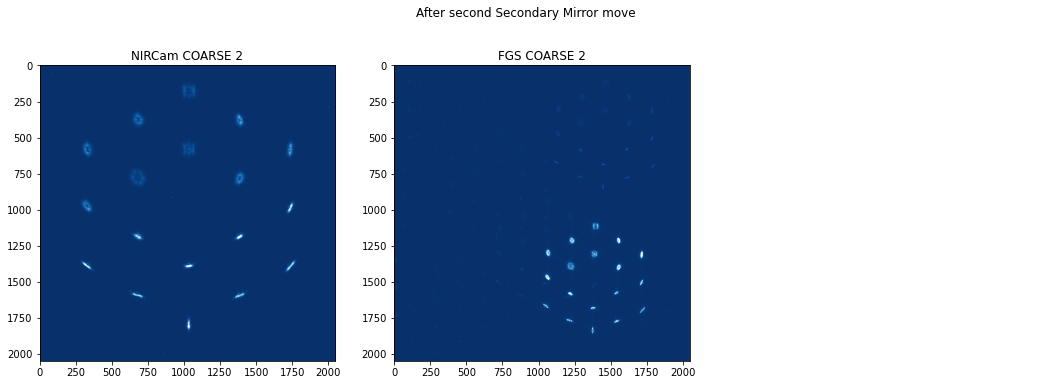

In [143]:
# Plot images
# Note that all images have the origin in the UPPER LEFT, matching the MAGIC orientation
try:
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(nircam_track_1, cmap='Blues_r', vmin=0, vmax=10000, origin='upper')
    ax[0].set_title('NIRCam TRACK 1')
    ax[1].axis('off')
    ax[2].axis('off')
    fig.suptitle("Before Secondary Mirror moves")
    plt.show()

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    ax[0].imshow(nircam_coarse_1, cmap='Blues_r', vmin=0, vmax=10000, origin='upper')
    ax[0].set_title('NIRCam COARSE 1')
    ax[1].imshow(fgs_coarse_1, cmap='Blues_r', vmin=0, vmax=50, origin='upper')
    ax[1].set_title('FGS COARSE 1')
    fig.suptitle("After first Secondary Mirror move")

    try:
        ax[2].imshow(nircam_track_2, cmap='Blues_r', vmin=0, vmax=10000, origin='upper')
        ax[2].set_title('NIRCam TRACK 2')
        plt.show()

        fig, ax = plt.subplots(1, 3, figsize=(18, 6))

        ax[0].imshow(nircam_coarse_2, cmap='Blues_r', vmin=0, vmax=10000, origin='upper')
        ax[0].set_title('NIRCam COARSE 2')
        ax[1].imshow(fgs_coarse_2, cmap='Blues_r', vmin=0, vmax=50, origin='upper')
        ax[1].set_title('FGS COARSE 2')
        ax[2].axis('off')
        fig.suptitle("After second Secondary Mirror move")
        
    except NameError:
        plt.show()
        print('Failure after first Secondary Mirror move')
except NameError:
    print('No full frame data NIRCam or FGS to show')

Remeber that the above images are in the SCI reference frame. Consult the image below to match segment names
<img src="psf_orientation_sci_magic.png" style="width: 300px;">

In the example, B6 is donut-y but the second mirror move and no longer a good candidate for guiding. This would be a case where you would want to choose a new configuration.

<font color='SlateBlue'> <div>

## CHECK 2: Were more than one bright objects found for selected PSFs?    
 
</div></font>

<font color='MediumSeaGreen'><div>
### Yes
</div></font>

Identify which bright objects are associated with each of the selected PSFs and look at their entries in the bright_obj_list data frame

In [116]:
# Make a list of the indices of the bright objects that have been found for 1 PSF
# Here we choose the second reference star in our example that has two entris in the bright object list
indices_of_interest = [9, 11]

one_psf = bright_object_df.loc[indices_of_interest]
one_psf

,Cand#,Strip#,CDS#,FPA Row (pixels),FPA Column (pixels),FPA Peak Signal (counts),FPA Count Sum (counts)
9,9,7,2,377,620,3043,22100
11,11,7,2,363,636,2649,20308


In [129]:
# Far away from each other are these two points (in pixels)
# Note that this will only work if there are two entries in the one_psf table
y1, y2 = one_psf['FPA Row (pixels)'].values
x1, x2 = one_psf['FPA Row (pixels)'].values

distance = np.sqrt((x2-x1)**2+(y2-y1)**2)

print(f'{np.round(distance, 2)} pixel separation')

19.8 pixel separation


In [119]:
ref2 = commanded.loc[[2]]

t_id = 0.3406 # seconds
ref2['id counts'] = ref2['countrate'].values*t_id
ref2['id threshold'] = ref2['threshold'].values*t_id

ref2

,y,x,countrate,threshold,id counts,id threshold
2,374.5,632.5,33700.0,20220.0,11478.22,6886.932


These two "bright objects" are within the track box. Check with the FGS team how this could impact guiding capabilities.

<font color='Tomato'><div>
### No
</div></font>

Perfect; that's what we like to see. Because it still failed, there is likely a geometry issue and you will need to follow **Recommendation 2**. Be sure to reference [this page](https://jwstitarwiki.stsci.edu/display/WFSCOWG/Selecting+Guide+and+Reference+Stars#SelectingGuideandReferenceStars-segmentgeometrySegmentGeometry) along with consulting how the PSFs have changed across mirror moves, when making new selections.

<font><div><center>
# Where do we go from here?
</center></div></font>

Take the information you have learned for each configuration and:
- Pass it back to the FGS team to see if your analysis matches what they have found and if they can help narrow down any questions you still have.
- Check in with WF Ops to see if there is a plan for what kind observation will be executed in order to recover from this anomaly 

Further steps are detailed on the [Guiding Contingencies](https://jwstitarwiki.stsci.edu/display/WFSCOWG/Guiding+Contingencies) page, but keep this notebook open as reference for when you make your next override file.

Good Luck!

### About this notebook:
Author: K. Brooks

Last Updated: 27 July, 2021